## Cluster Technique Search and Analysis

In [5]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
# from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import matplotlib.cm as cm
import matplotlib.pyplot as plt
#SPECIFIED CLUSTER DISCOVERY
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering,\
MeanShift, AffinityPropagation, DBSCAN, OPTICS, Birch
from sklearn.metrics import silhouette_score, silhouette_samples
import tabulate

In [6]:
# load pipeline 1 csv and prep for clustering
m2_pipeline = pd.read_csv('../0 Data Processing/binned_pipeline.csv')

In [16]:
# check varibales
m2_pipeline.iloc[0,:]

group                                           2
time                              1660221654244.0
s_MP                                         30.0
change                                  -0.000533
type                                    precursor
p_MP                                        29.98
precursor_buy_cap_pct_change            -0.000044
precursor_ask_cap_pct_change            -0.000004
precursor_bid_vol_pct_change            -0.000017
precursor_ask_vol_pct_change            -0.000351
length                                          6
sum_change                               -0.00501
max_surge_mp                                 30.0
min_surge_mp                                 30.0
max_precursor_mp                            29.98
min_precursor_mp                            29.85
area                                    -0.030057
surge_targets_met_pct                   -0.066667
group.1                                         3
time.1                            1660221833233.0


In [17]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length',
            'surge_targets_met_pct', 'label']
x = m2_pipeline[['surge_targets_met_pct']].values.astype(float)
m2_pipeline = m2_pipeline[keepable]

In [18]:
m2_pipeline

,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,surge_targets_met_pct,label
0,-0.000044,-0.000004,-0.000017,-0.000351,-5.009518e-03,6,-0.066667,4
1,-0.002358,-0.000002,-0.000818,-0.000333,1.345640e-04,1,0.100469,5
2,-0.001354,-0.000017,-0.000446,-0.001967,-3.410602e-03,3,0.133779,6
3,-0.000514,0.000017,-0.000278,0.001923,8.855895e-07,2,-0.033467,4
4,0.014278,0.000034,0.006498,0.008866,-1.377036e-02,7,0.167224,6
...,...,...,...,...,...,...,...,...
5725,-0.007939,-0.000315,-0.001930,-0.000743,-2.389645e-03,2,-0.099502,4
5726,-0.604637,-0.990184,0.384741,-0.122234,-3.020852e-01,5,0.000000,4
5727,-0.001037,-0.000074,-0.000258,-0.000349,-4.980070e-04,5,0.099800,5
5728,0.010895,-0.000219,0.002650,-0.000977,-9.952165e-04,18,0.000000,4


### Standardize all features and split into train/test

In [19]:
m2_pipeline = m2_pipeline.dropna()

# Splitting the dataframe into features and labels
X = m2_pipeline[['precursor_buy_cap_pct_change', 'precursor_ask_cap_pct_change','precursor_bid_vol_pct_change',
                'precursor_ask_vol_pct_change','sum_change', 'length']]
y = m2_pipeline[['surge_targets_met_pct','label']]

# Performing the test/train split and standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
def silhouette_scorer(estimator, X, y=None):
    labels = estimator.fit_predict(X)
    score = silhouette_score(X, labels)
    return score

In [14]:
def cluster_profitability(model, X, feature_name):
    """
    Compute the profitability score of the clustering model.
    
    Parameters:
    - model: Fitted clustering model
    - X: DataFrame, the original data with all features
    - feature_name: str, the name of the feature to compute profitability
    
    Returns:
    - score: float, computed profitability score
    """
    labels = model.labels_
    df = pd.concat([X.reset_index(drop=True), pd.Series(labels, name='Cluster_Label')], axis=1)
    cluster_means = df.groupby('Cluster_Label')[feature_name].mean()
    
    # Custom scoring logic here. 
    score = cluster_means.std()  # Standard deviation between cluster means
    
    return score


### Iterate through Cluetering Techniques
First Techniques where cluster count needs to be itnialized then techniques that do not need to be intialized

In [27]:
# Define a range for n_clusters
n_clusters_options = [2, 3, 4, 5, 6, 7, 8, 9, 10,11,12]

# Define your models
clustering_models = [
    ('KMeans', KMeans(random_state =42)),
    ('Birch', Birch()),
    ('Hierarchical', AgglomerativeClustering())
]

results_df = pd.DataFrame(columns=['algo', 'n_clusters', 'score', 'profit'])

# Loop over the models
for model_name, model in clustering_models:
    # Loop over the n_clusters options
    for n_clusters in n_clusters_options:
        # Set the number of clusters and fit the model
        model.set_params(n_clusters=n_clusters)
        labels = model.fit_predict(X_train_scaled)

        # Evaluate using the silhouette score
        score = silhouette_score(X_train_scaled, labels)
        # Compute profitability score
        profit = cluster_profitability(model, y_train, 'surge_targets_met_pct')

        # Store the best parameters, model, and score
        print(f'{model_name} with {n_clusters} clusters:')
        print(f'Silhouette score: {score:.4f}')
        print(f'Profitability score: {profit:.4f}\n')

        
        results_df = results_df.append({
            'algo': model_name, 
            'n_clusters': n_clusters, 
            'score': score,
            'profit': profit
        }, ignore_index=True)
        
 

KMeans with 2 clusters:
Silhouette score: 0.8889
Profitability score: 0.0346

KMeans with 3 clusters:
Silhouette score: 0.8121
Profitability score: 0.0299

KMeans with 4 clusters:
Silhouette score: 0.8131
Profitability score: 0.1545

KMeans with 5 clusters:
Silhouette score: 0.5271
Profitability score: 0.1346

KMeans with 6 clusters:
Silhouette score: 0.5474
Profitability score: 0.1151

KMeans with 7 clusters:
Silhouette score: 0.5121
Profitability score: 0.1177

KMeans with 8 clusters:
Silhouette score: 0.5543
Profitability score: 0.1967

KMeans with 9 clusters:
Silhouette score: 0.5649
Profitability score: 0.1894

KMeans with 10 clusters:
Silhouette score: 0.4653
Profitability score: 0.1781

KMeans with 11 clusters:
Silhouette score: 0.5036
Profitability score: 0.1768

KMeans with 12 clusters:
Silhouette score: 0.4622
Profitability score: 0.1746

Birch with 2 clusters:
Silhouette score: 0.8696
Profitability score: 0.0090

Birch with 3 clusters:
Silhouette score: 0.8507
Profitability 

In [16]:
clustering_models = [
    ('Meanshift',  MeanShift( bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=None, max_iter=300)),
    ('AffinityPropagation', AffinityPropagation( damping=0.5, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', verbose=False, random_state=42)),
    ('DBSCAN', DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)),
    ('OPTICS', OPTICS( min_samples=5, max_eps=3, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, n_jobs=None))]

In [14]:

# Loop over the models
for model_name, model in clustering_models:

    labels = model.fit_predict(X_train_scaled)
    n_clusters = len(set(labels))
    # Evaluate using the silhouette score
    if n_clusters > 1:
        # Evaluate using the silhouette score
        score = silhouette_score(X_train_scaled, labels)
        profit = cluster_profitability(model, y_train, 'surge_targets_met_pct')
    else:
        score = None  # or another indicator value, or you might log/print a message and continue
    # Compute profitability score
        profit =  None 
    # Store the best parameters, model, and score
    print(f'{model_name} with {n_clusters} clusters:')
    if n_clusters > 1:
        print(f'Silhouette score: {score:.4f}')
        print(f'Profitability score: {profit:.4f}\n')


    results_df = results_df.append({
        'algo': model_name, 
        'n_clusters': n_clusters, 
        'score': score,
        'profit': profit
    }, ignore_index=True)
        
 

Meanshift with 175 clusters:
Silhouette score: 0.4776
Profitability score: 0.4228

AffinityPropagation with 1 clusters:
DBSCAN with 10 clusters:
Silhouette score: 0.4413
Profitability score: 0.0989

OPTICS with 114 clusters:
Silhouette score: -0.5760
Profitability score: 0.1114



In [28]:
sorted_df = results_df.sort_values(by='profit', ascending=False)
sorted_df

,algo,n_clusters,score,profit
16,Birch,7,0.739760,0.217987
18,Birch,9,0.563139,0.207827
21,Birch,12,0.527189,0.204684
17,Birch,8,0.562683,0.203530
20,Birch,11,0.563999,0.203139
19,Birch,10,0.563539,0.201124
6,KMeans,8,0.554268,0.196746
29,Hierarchical,9,0.460035,0.195590
7,KMeans,9,0.564890,0.189434
32,Hierarchical,12,0.464249,0.189376


In [32]:
from tabulate import tabulate

filtered_df = results_df[results_df['algo'].isin(['KMeans'])]

# Convert the dataframe to a table and print it
print(tabulate(filtered_df, headers='keys', tablefmt='grid'))


+----+--------+--------------+----------+-----------+
|    | algo   |   n_clusters |    score |    profit |
+====+========+==============+==========+===========+
|  0 | KMeans |            2 | 0.888867 | 0.0345768 |
+----+--------+--------------+----------+-----------+
|  1 | KMeans |            3 | 0.81207  | 0.0299211 |
+----+--------+--------------+----------+-----------+
|  2 | KMeans |            4 | 0.813111 | 0.154526  |
+----+--------+--------------+----------+-----------+
|  3 | KMeans |            5 | 0.527146 | 0.134555  |
+----+--------+--------------+----------+-----------+
|  4 | KMeans |            6 | 0.547412 | 0.115097  |
+----+--------+--------------+----------+-----------+
|  5 | KMeans |            7 | 0.512092 | 0.117663  |
+----+--------+--------------+----------+-----------+
|  6 | KMeans |            8 | 0.554268 | 0.196746  |
+----+--------+--------------+----------+-----------+
|  7 | KMeans |            9 | 0.56489  | 0.189434  |
+----+--------+-------------

In [33]:
from tabulate import tabulate

filtered_df = results_df[results_df['algo'].isin(['Birch'])]

# Convert the dataframe to a table and print it
print(tabulate(filtered_df, headers='keys', tablefmt='grid'))


+----+--------+--------------+----------+------------+
|    | algo   |   n_clusters |    score |     profit |
+====+========+==============+==========+============+
| 11 | Birch  |            2 | 0.869585 | 0.00896072 |
+----+--------+--------------+----------+------------+
| 12 | Birch  |            3 | 0.850691 | 0.152463   |
+----+--------+--------------+----------+------------+
| 13 | Birch  |            4 | 0.758282 | 0.131287   |
+----+--------+--------------+----------+------------+
| 14 | Birch  |            5 | 0.765198 | 0.123945   |
+----+--------+--------------+----------+------------+
| 15 | Birch  |            6 | 0.739571 | 0.14581    |
+----+--------+--------------+----------+------------+
| 16 | Birch  |            7 | 0.73976  | 0.217987   |
+----+--------+--------------+----------+------------+
| 17 | Birch  |            8 | 0.562683 | 0.20353    |
+----+--------+--------------+----------+------------+
| 18 | Birch  |            9 | 0.563139 | 0.207827   |
+----+----

In [15]:
# cluster profit function that works within grid search
def cluster_profitability_scorer(estimator, X):
    labels = estimator.labels_
    df = pd.concat([y_train.reset_index(drop=True), pd.Series(labels, name='Cluster_Label')], axis=1)
    cluster_means = df.groupby('Cluster_Label')['surge_targets_met_pct'].mean()
    score = cluster_means.std()
    
    return score

In [16]:
# Grid Search on Birch
# Model instantiation for BIRCH
model_birch = Birch()

# Parameter grid for BIRCH
param_grid_birch = {
    'threshold': [0.1, 0.25, 0.5, 0.75],
    'branching_factor': [20, 30, 40, 50],
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'copy': [True, False]
}

grid_search_birch = GridSearchCV(
    estimator=model_birch,
    param_grid=param_grid_birch,
    scoring=cluster_profitability_scorer,
)

grid_search_birch.fit(X_train_scaled, y=None)


GridSearchCV(estimator=Birch(),
             param_grid={'branching_factor': [20, 30, 40, 50],
                         'copy': [True, False],
                         'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'threshold': [0.1, 0.25, 0.5, 0.75]},
             scoring=<function cluster_profitability_scorer at 0x7f957cd3a950>)

In [17]:
best_params_birch = grid_search_birch.best_params_

## Run Birch on Best Params and Visualize train and test results

Counter({1: 4150, 3: 178, 9: 118, 2: 36, 0: 31, 10: 23, 4: 22, 8: 19, 5: 3, 7: 3, 6: 1})


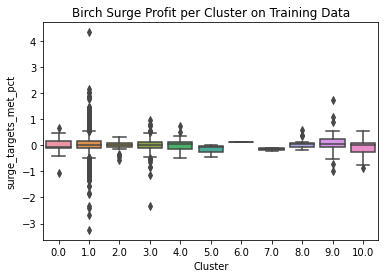

Counter({1: 1033, 3: 43, 9: 35, 2: 18, 10: 5, 0: 4, 4: 3, 8: 2, 6: 1, 7: 1, 5: 1})


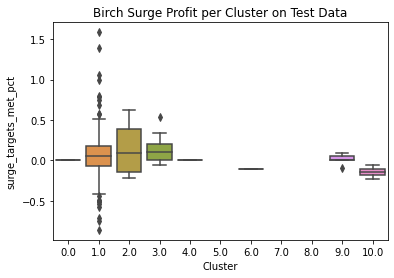

In [42]:
import seaborn as sns
bir = Birch(**best_params_birch)
train_labels_birch = bir.fit_predict(X_train_scaled)
df = pd.concat([y_train.reset_index(drop=True), pd.Series(train_labels_birch, name='Cluster_Label')], axis=1)
cluster_means_birch = df.groupby('Cluster_Label')['surge_targets_met_pct'].mean()
# Custom scoring logic here. 
score = cluster_means_birch.std() 

from collections import Counter
train_counts_birch = Counter(list(train_labels_birch))
print(train_counts_birch)

# Create the Train Data Boxplot
clustered_data = pd.concat([y_train, pd.Series(train_labels_birch, name='Cluster')], axis=1)
ax = sns.boxplot(x='Cluster', y='surge_targets_met_pct', data=clustered_data)

# Set the title for the plot
ax.set_title("Birch Surge Profit per Cluster on Training Data")
# Display the plot
plt.show()


# Create the Test Data Boxplot
test_labels_birch = bir.predict(X_test_scaled)
from collections import Counter
test_counts_birch = Counter(list(test_labels_birch))
print(test_counts_birch)

clustered_data = pd.concat([y_test, pd.Series(test_labels_birch, name='Cluster')], axis=1)
ax = sns.boxplot(x='Cluster', y='surge_targets_met_pct', data=clustered_data)

# Set the title for the plot
ax.set_title("Birch Surge Profit per Cluster on Test Data")

# Display the plot
plt.show()

In [34]:
# Grid Search for KMeans

from sklearn.metrics import make_scorer
from functools import partial
model = KMeans(random_state=42)


param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10,11,12],
    'init': ['k-means++', 'random'],
    'n_init': [10, 15, 20],
    'max_iter': [200, 300, 400],
    'algorithm': ['auto', 'elkan']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=cluster_profitability_scorer,
)

# assuming X_train_scaled is your preprocessed data
grid_search.fit(X_train_scaled, y=None)


GridSearchCV(estimator=KMeans(random_state=42),
             param_grid={'algorithm': ['auto', 'elkan'],
                         'init': ['k-means++', 'random'],
                         'max_iter': [200, 300, 400],
                         'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'n_init': [10, 15, 20]},
             scoring=<function cluster_profitability_scorer at 0x7fac0c196200>)

In [48]:
kmeans_results = pd.DataFrame(grid_search.cv_results_)

In [49]:
best_params = grid_search.best_params_

## Run KMeans on Best Params and Visualize train and test results

In [51]:
clf = KMeans(**best_params,random_state = 42)
train_labels = clf.fit_predict(X_train_scaled)
df = pd.concat([y_train.reset_index(drop=True), pd.Series(train_labels, name='Cluster_Label')], axis=1)
cluster_means = df.groupby('Cluster_Label')['surge_targets_met_pct'].mean()
    
# Custom scoring logic here. 
score = cluster_means.std() 

from collections import Counter
train_counts = Counter(list(train_labels))
print(train_counts)

# Create the Train Data Boxplot
clustered_data = pd.concat([y_train, pd.Series(train_labels, name='Cluster')], axis=1)
ax = sns.boxplot(x='Cluster', y='surge_targets_met_pct', data=clustered_data)

# Set the title for the plot
ax.set_title("Surge Profit per Cluster on Training Data")
# Display the plot
plt.show()


# Create the Test Data Boxplot
test_labels = clf.predict(X_test_scaled)
from collections import Counter
test_counts = Counter(list(test_labels))
print(train_counts)


clustered_data = pd.concat([y_test, pd.Series(test_labels, name='Cluster')], axis=1)
ax = sns.boxplot(x='Cluster', y='surge_targets_met_pct', data=clustered_data)

# Set the title for the plot
ax.set_title("Surge Profit per Cluster on Test Data")

# Display the plot
plt.show()

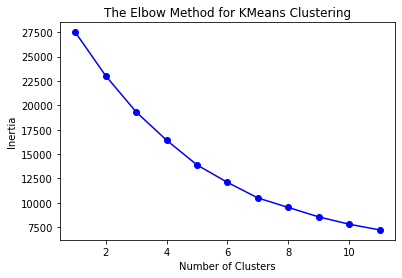

In [18]:
# K Means Visualizations
# Calculate the sum of squared distances (inertia) for different values of k
inertia = []
range_values = range(1, 12) 
for k in range_values:
    kmeans = KMeans(n_clusters=k, init ="k-means++", max_iter = 200,n_init=10, random_state = 42 )
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure()
plt.plot(range_values, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method for KMeans Clustering')
plt.show()


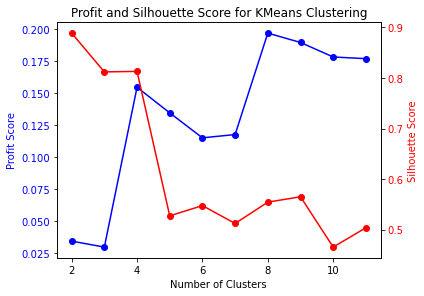

In [19]:
# Calculate silhouette scores for different values of k
sil_scores = []
profit_scores = []
range_values = range(2, 12)  

for k in range_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=200, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    
    # Silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(X_train_scaled, cluster_labels)
    sil_scores.append(silhouette_avg)
    # Profit score for the current number of clusters
    df = pd.concat([y_train.reset_index(drop=True), pd.Series(cluster_labels, name='Cluster_Label')], axis=1)
    cluster_means = df.groupby('Cluster_Label')['surge_targets_met_pct'].mean() 
    profit_score = cluster_means.std() 
    profit_scores.append(profit_score)
fig, ax1 = plt.subplots()


# Plot Profit Score on the left y-axisa
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Profit Score', color='b')
ax1.plot(range_values, profit_scores, 'bo-')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()  # create a second axes that shares the same x-axis

# Plot Silhouette Score on the right y-axis
ax2.set_ylabel('Silhouette Score', color='r')  
ax2.plot(range_values, sil_scores, 'ro-')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Profit and Silhouette Score for KMeans Clustering')
plt.show()

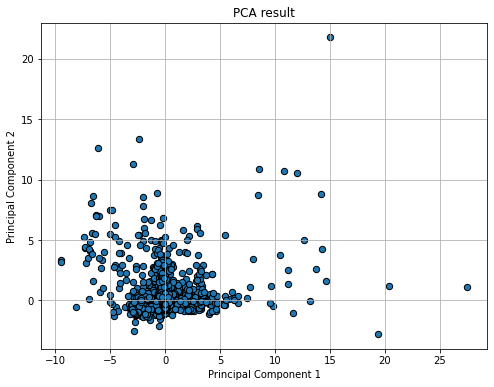

In [31]:

from sklearn.decomposition import PCA
# Initialize PCA and the X vector for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Plot the PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='k', s=40)
plt.title('PCA result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


For n_clusters = 2 The average silhouette_score is : 0.8994711093337463
For n_clusters = 4 The average silhouette_score is : 0.7461479541409018
For n_clusters = 8 The average silhouette_score is : 0.5620502328392872
For n_clusters = 9 The average silhouette_score is : 0.5167945503543088
For n_clusters = 10 The average silhouette_score is : 0.5180126626932116
For n_clusters = 11 The average silhouette_score is : 0.5100824967230934


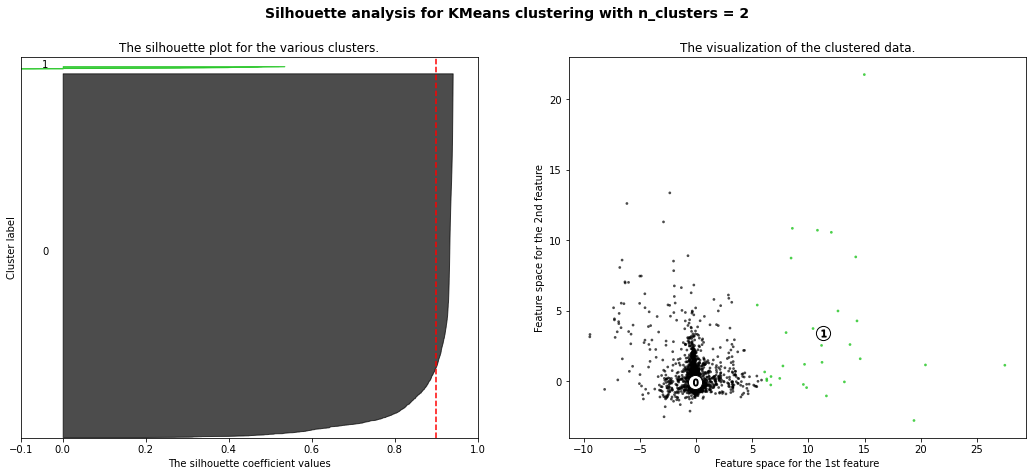

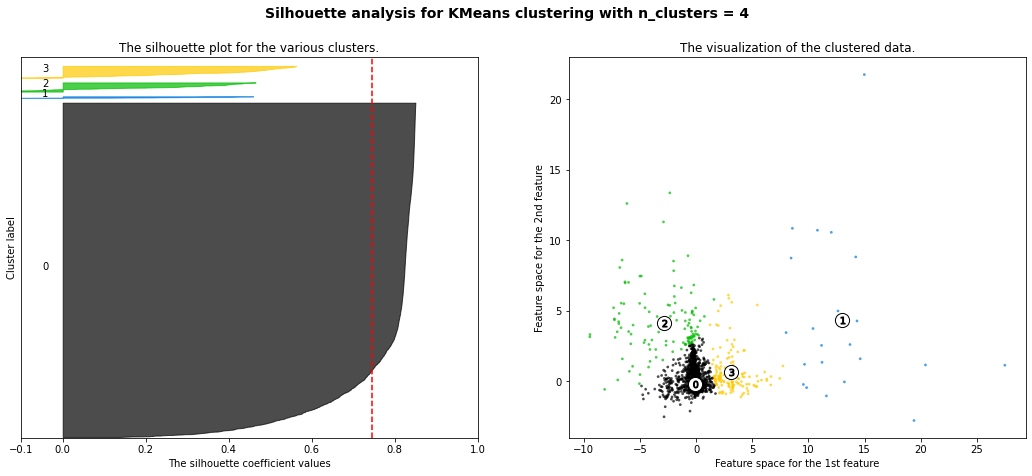

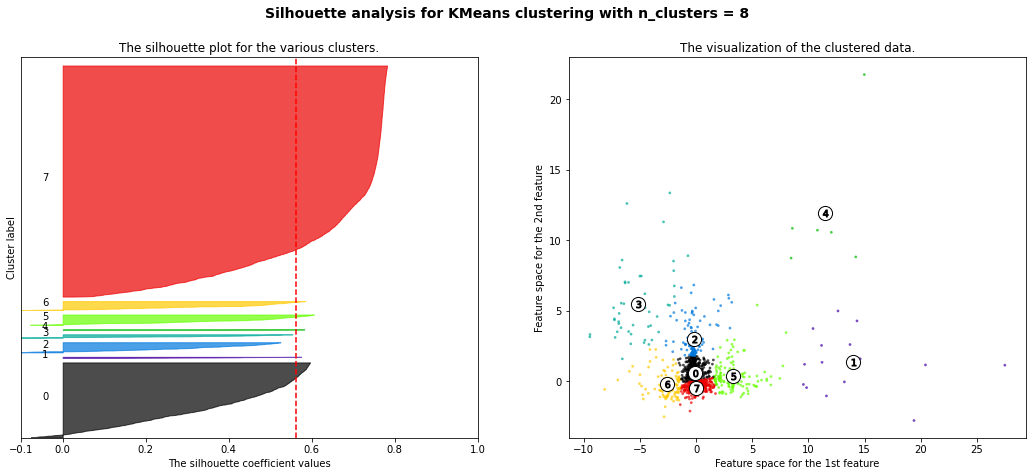

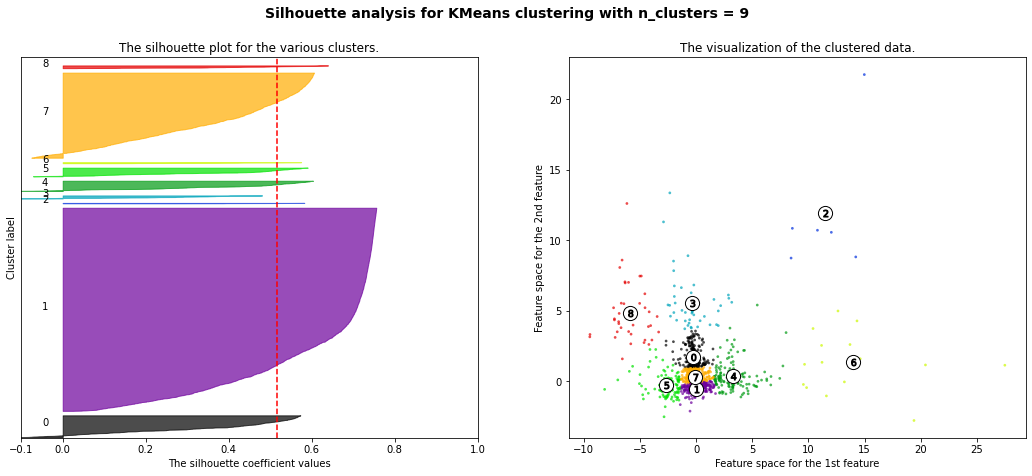

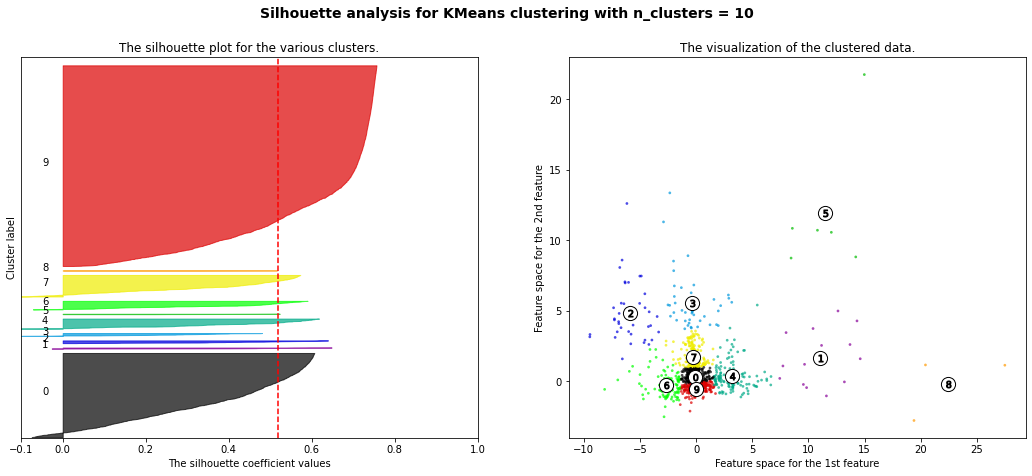

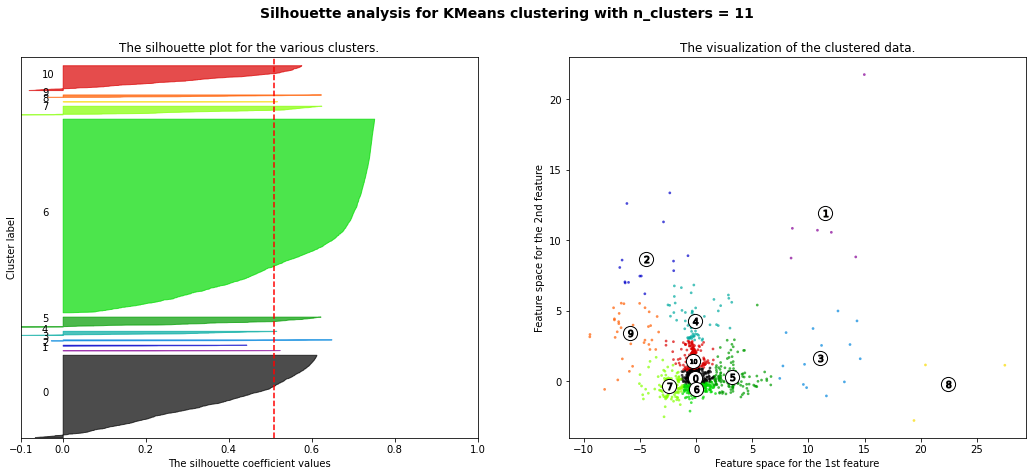

In [32]:
# Sihouette Analysis for KMeans
range_n_clusters = [2,4, 8, 9, 10, 11]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 60])

    # Initialize the clusterer with n_clusters value
    params['n_clusters'] = n_clusters
    clusterer = KMeans(**params)
    cluster_labels = clusterer.fit_predict(X_pca)

    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 60

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

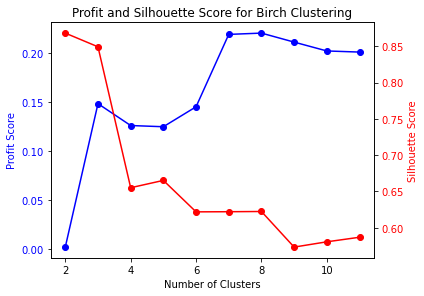

In [24]:
# Calculate silhouette scores for different values of k
sil_scores = []
profit_scores = []
range_values = range(2, 12)  

for k in range_values:
    bir = Birch(n_clusters=k,branching_factor= 30, copy = True, threshold=0.5 )
    cluster_labels = bir.fit_predict(X_train_scaled)
    
    # Silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(X_train_scaled, cluster_labels)
    sil_scores.append(silhouette_avg)
    # Profit score for the current number of clusters
    df = pd.concat([y_train.reset_index(drop=True), pd.Series(cluster_labels, name='Cluster_Label')], axis=1)
    cluster_means = df.groupby('Cluster_Label')['surge_targets_met_pct'].mean() 
    profit_score = cluster_means.std() 
    profit_scores.append(profit_score)
fig, ax1 = plt.subplots()


# Plot Profit Score on the left y-axisa
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Profit Score', color='b')
ax1.plot(range_values, profit_scores, 'bo-')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()  # create a second axes that shares the same x-axis

# Plot Silhouette Score on the right y-axis
ax2.set_ylabel('Silhouette Score', color='r')
ax2.plot(range_values, sil_scores, 'ro-')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Profit and Silhouette Score for Birch Clustering')
plt.show()